# Imports

In [1]:
import pandas as pd
import os
import numpy as np
from Bio import SeqIO
from collections import Counter
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# load data 

In [2]:
braker = pd.read_csv('./braker.gff3_red', sep='\t')

In [3]:
# get gene_ids for each entry
braker['gene_id'] = [i.rsplit('.',1)[0] for i in braker.ID]

In [4]:
# group by gid, get gid:scaffold dict
bgb = braker.groupby('gene_id')
scdict = {k.gene_id:k.Scaffold for i, k in  braker.iterrows()}

In [5]:
# get dataframe with start & stop positions for each gene, add scaffold id columns
start_stop_df = pd.DataFrame([bgb['Start_pos'].min(),bgb['End_pos'].max()]).T
start_stop_df['scaffold'] = [scdict[i] for i in start_stop_df.index]

In [ ]:
# save start-stop dataframe to file
#start_stop_df.to_csv('20230714_Mbel_gene_start_stop.tsv', sep='\t')

In [6]:
# load the very same file
start_stop_df = pd.read_csv('20230714_Mbel_gene_start_stop.tsv', sep='\t', index_col=0)

# define support functions

In [7]:
def create_and_submit_sbatch(batch, chunk):
    name="CpG_gene_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Mbel_per_gene_cpg.py --input {chunk} --flanksize 1e3".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [8]:
def create_and_submit_sbatch(batch, chunk):
    name="CpG_gene_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 6:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Mbel_per_gene_cpg_with_buffer.py --input {chunk} --flanksize 50000 --flankbuffer 10000".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [60]:
def create_and_submit_sbatch_CpG_ex_in(batch, chunk):
    name="CpG_gene_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Mbel_exin_cpg.py --input {chunk}".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

# get CpG for genes and flanking regions

In [9]:
#split into chunks and write them
chunk_n = 500
ss_split = np.array_split(start_stop_df, chunk_n)

In [10]:
cfiles = []
for i, k in enumerate(ss_split):
    #print(i)
    chunkname = "ss_chunks_500_CpG_flank/ss_chunk{chunk_i}.chunk".format(chunk_i=i)
    k.to_csv(chunkname, sep='\t')
    create_and_submit_sbatch(batch=i, chunk=chunkname)

Submitted batch job 40107429
Submitted batch job 40107430
Submitted batch job 40107431
Submitted batch job 40107432
Submitted batch job 40107433
Submitted batch job 40107434
Submitted batch job 40107435
Submitted batch job 40107436
Submitted batch job 40107437
Submitted batch job 40107438
Submitted batch job 40107439
Submitted batch job 40107440
Submitted batch job 40107441
Submitted batch job 40107442
Submitted batch job 40107443
Submitted batch job 40107444
Submitted batch job 40107445
Submitted batch job 40107446
Submitted batch job 40107447
Submitted batch job 40107448
Submitted batch job 40107449
Submitted batch job 40107450
Submitted batch job 40107451
Submitted batch job 40107452
Submitted batch job 40107453
Submitted batch job 40107454
Submitted batch job 40107455
Submitted batch job 40107456
Submitted batch job 40107457
Submitted batch job 40107458
Submitted batch job 40107459
Submitted batch job 40107460
Submitted batch job 40107461
Submitted batch job 40107462
Submitted batc

# get CpG for  genetic elements within the gene

In [6]:
#split into chunks and write them
chunk_n = 200
braker_split = np.array_split(braker, chunk_n)

In [7]:
braker_split[0]

,Scaffold,Type,Start_pos,End_pos,ID,gene_id
0,scaffold1,start_codon,38182802,38182804,g21734.t1.start1,g21734.t1
1,scaffold1,CDS,38182802,38182838,g21734.t1.CDS1,g21734.t1
2,scaffold1,exon,38182802,38182838,g21734.t1.exon1,g21734.t1
3,scaffold1,intron,38182839,38182894,g21734.t1.intron1,g21734.t1
4,scaffold1,CDS,38182895,38182961,g21734.t1.CDS2,g21734.t1
...,...,...,...,...,...,...
4135,scaffold35,exon,4447856,4447919,g8731.t1.exon12,g8731.t1
4136,scaffold35,stop_codon,4447917,4447919,g8731.t1.stop1,g8731.t1
4137,scaffold18,start_codon,3150816,3150818,g19239.t1.start1,g19239.t1
4138,scaffold18,CDS,3150816,3150984,g19239.t1.CDS1,g19239.t1


In [64]:
for i, k in enumerate(braker_split):
    #print(i)
    chunkname = "braker_chunks2/braker_chunk_{chunk_i}.gff3_chunk".format(chunk_i=i)
    #k.to_csv(chunkname)
    create_and_submit_sbatch_CpG_ex_in(batch=i, chunk=chunkname)

Submitted batch job 39559599
Submitted batch job 39559600
Submitted batch job 39559601
Submitted batch job 39559602
Submitted batch job 39559603
Submitted batch job 39559604
Submitted batch job 39559605
Submitted batch job 39559606
Submitted batch job 39559607
Submitted batch job 39559608
Submitted batch job 39559609
Submitted batch job 39559610
Submitted batch job 39559611
Submitted batch job 39559612
Submitted batch job 39559613
Submitted batch job 39559614
Submitted batch job 39559615
Submitted batch job 39559616
Submitted batch job 39559617
Submitted batch job 39559618
Submitted batch job 39559619
Submitted batch job 39559621
Submitted batch job 39559622
Submitted batch job 39559623
Submitted batch job 39559624
Submitted batch job 39559625
Submitted batch job 39559626
Submitted batch job 39559627
Submitted batch job 39559628
Submitted batch job 39559629
Submitted batch job 39559630
Submitted batch job 39559631
Submitted batch job 39559632
Submitted batch job 39559633
Submitted batc

# gather data and make figures

## get gene/flanking comparison

In [3]:
cpg_chunks =  [ i for i in os.listdir("./ss_chunks") if i.endswith(".cpg")]
cpg_chunks = [i for i in cpg_chunks if not i.startswith('test')]
cpg_chunks_df = pd.concat([pd.read_csv(os.path.join("./ss_chunks",i), sep='\t', index_col=0) for i in cpg_chunks])
cpg_chunks_df.to_csv('./20230717_Mbel_CpG_per_gene_and_1e3flankingregions.tsv', sep='\t')

In [8]:
cpg_chunks_df_melt = cpg_chunks_df.melt(id_vars=['ID'], value_vars=['gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o','flank_u_cpg_oe','flank_d_cpg_e','flank_d_cpg_o','flank_d_cpg_oe'] )

In [ ]:
cpg_chunks_df_melt_oe = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable.isin(['gene_cpg_oe', 'flank_u_cpg_oe', 'flank_d_cpg_oe'])]

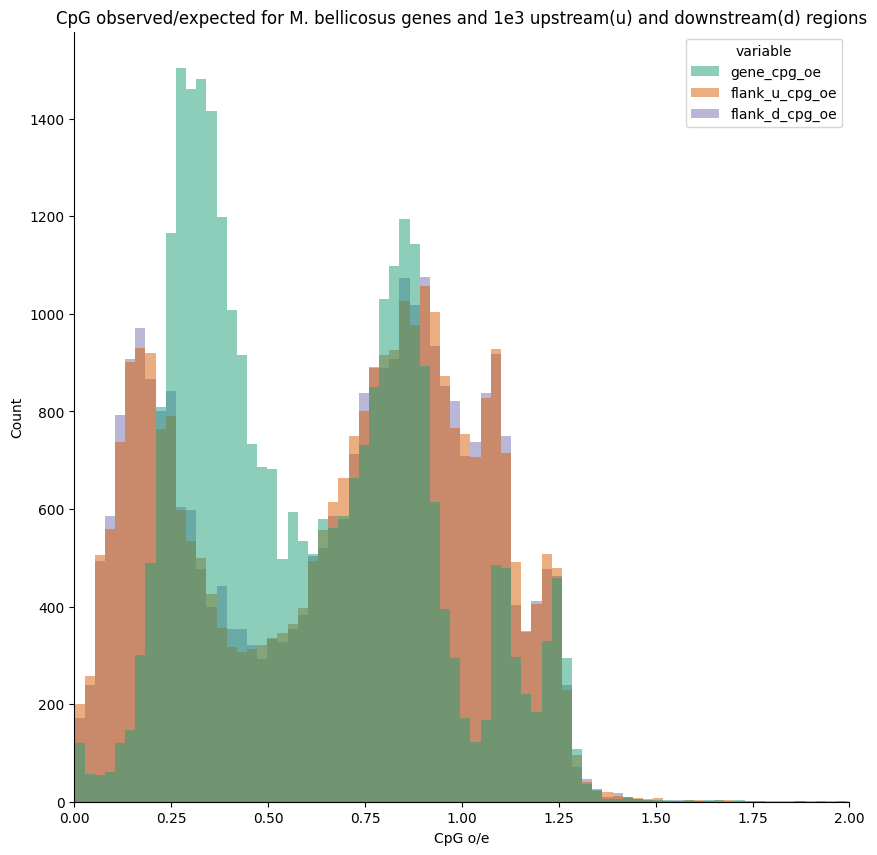

In [72]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=cpg_chunks_df_melt_oe, x="value", hue="variable",linewidth=0, palette = ['#1b9e77','#d95f02','#7570b3'])

ax.set_xlim(0,2)
ax.set_title('CpG observed/expected for M. bellicosus genes and 1e3 upstream(u) and downstream(d) regions')
ax.set_xlabel('CpG o/e')

sns.despine()
plt.show()


In [ ]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax)
sns.boxenplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax1)
sns.violinplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax2)
#sns.striplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', hue='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax3, alpha=0.1, s=1)

plt.tight_layout()
plt.show()

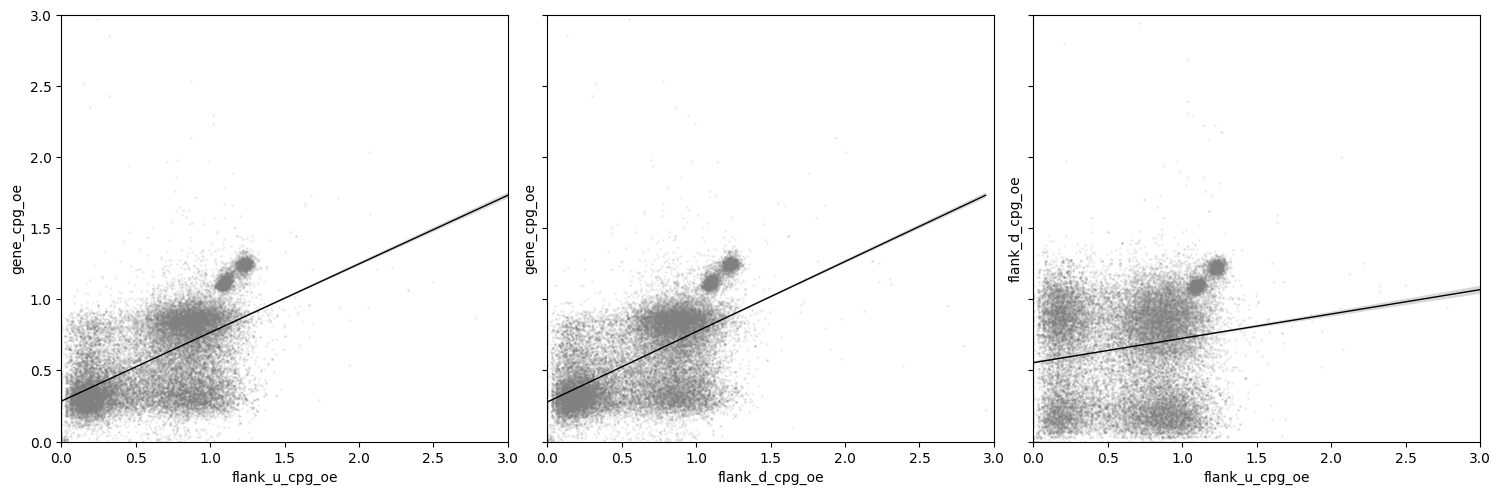

In [127]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="gene_cpg_oe", ax=ax, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )
sns.regplot(data=cpg_chunks_df, x="flank_d_cpg_oe", y="gene_cpg_oe", ax=ax1, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )
sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="flank_d_cpg_oe", ax=ax2, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )

plt.tight_layout()
ax.set_ylim(0,3)
ax.set_xlim(0,3)

plt.show()

# exon/intron comparison

In [92]:
cpg_chunks_exin =  [ i for i in os.listdir("./braker_chunks2") if i.endswith("gene_ex_in.cpg")]

In [129]:
cpg_chunks_exin = [i for i in cpg_chunks_exin if not i.startswith('test')]
cpg_chunks_exin_df = pd.concat([pd.read_csv(os.path.join("./braker_chunks2",i), sep='\t', index_col=0) for i in cpg_chunks_exin])
cpg_chunks_exin_df.to_csv('./20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t')

In [130]:
cpg_chunks_exin_df['gene_id'] = [i.rsplit('.',1)[0] for i in cpg_chunks_exin_df.ID]
cpg_chunks_exin_df['reg_id'] = [i.rsplit('.',1)[1] for i in cpg_chunks_exin_df.ID]

In [135]:
cpg_chunks_exin_df['reg_type'] = [''.join(i for i in st if i.isalpha()) for st in cpg_chunks_exin_df.reg_id]


In [138]:
cpg_chunks_exin_df_onlyexin = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type.isin(['exon', 'intron'])]

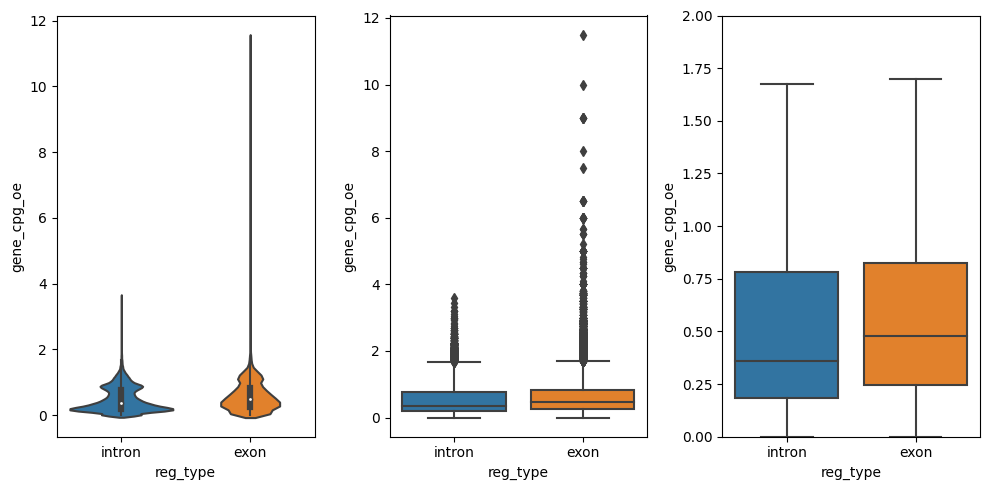

In [208]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5))

sns.violinplot(data=cpg_chunks_exin_df_onlyexin, x='reg_type', y='gene_cpg_oe', ax=ax)
sns.boxplot(data=cpg_chunks_exin_df_onlyexin, x='reg_type', y='gene_cpg_oe', ax=ax1)
sns.boxplot(data=cpg_chunks_exin_df_onlyexin, x='reg_type', y='gene_cpg_oe', ax=ax2, fliersize=0)

ax2.set_ylim(0,2)
plt.tight_layout()
plt.show()

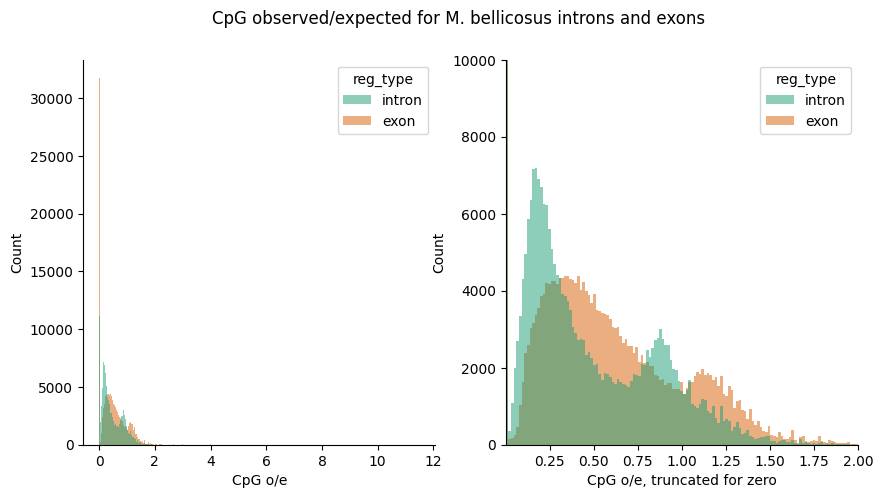

In [151]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=cpg_chunks_exin_df_onlyexin, x="gene_cpg_oe", hue="reg_type",linewidth=0, palette = ['#1b9e77','#d95f02'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('CpG observed/expected for M. bellicosus introns and exons')
ax.set_xlabel('CpG o/e')

sns.histplot(data=cpg_chunks_exin_df_onlyexin, x="gene_cpg_oe", hue="reg_type",linewidth=0, palette = ['#1b9e77','#d95f02'] ,ax=ax1)
ax1.set_xlim(0.001,2)
ax1.set_ylim(0,10000)
ax1.set_xlabel('CpG o/e, truncated for zero')

sns.despine()
plt.show()

# compare exons / introns / flanks

In [153]:
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].mean()

reg_type
exon      0.564167
intron    0.482606
Name: gene_cpg_oe, dtype: float64

In [160]:
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].sem()

reg_type
exon      0.000850
intron    0.000768
Name: gene_cpg_oe, dtype: float64

In [169]:
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].std()

reg_type
exon      0.438275
intron    0.372242
Name: gene_cpg_oe, dtype: float64

In [155]:
cpg_chunks_df_melt.groupby('variable')['value'].mean()

variable
flank_d_cpg_e      46.199246
flank_d_cpg_o      35.893747
flank_d_cpg_oe      0.670841
flank_u_cpg_e      46.295592
flank_u_cpg_o      36.151314
flank_u_cpg_oe      0.675701
gene_cpg_e        952.266184
gene_cpg_o        556.715135
gene_cpg_oe         0.610133
Name: value, dtype: float64

In [161]:
cpg_chunks_df_melt.groupby('variable')['value'].sem()

variable
flank_d_cpg_e     0.153146
flank_d_cpg_o     0.216294
flank_d_cpg_oe    0.002071
flank_u_cpg_e     0.152904
flank_u_cpg_o     0.215739
flank_u_cpg_oe    0.002071
gene_cpg_e        7.648412
gene_cpg_o        5.236438
gene_cpg_oe       0.001764
Name: value, dtype: float64

In [168]:
cpg_chunks_df_melt.groupby('variable')['value'].std()

variable
flank_d_cpg_e       26.800536
flank_d_cpg_o       37.851448
flank_d_cpg_oe       0.362396
flank_u_cpg_e       26.758266
flank_u_cpg_o       37.754285
flank_u_cpg_oe       0.362441
gene_cpg_e        1338.472043
gene_cpg_o         916.376737
gene_cpg_oe          0.308645
Name: value, dtype: float64

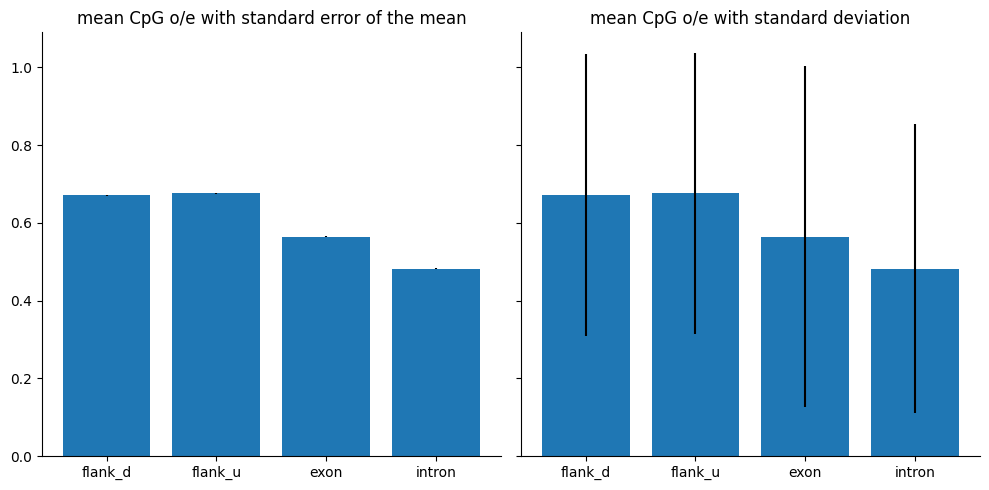

In [199]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharey=True)
ax.bar(height = [0.670841,0.675701, 0.564167,0.482606 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.002071,0.002071,0.000850,0.000768])
ax1.bar(height = [0.670841,0.675701, 0.564167,0.482606 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.362396,0.362441,0.438275,0.372242])

ax.set_title("mean CpG o/e with standard error of the mean")
ax1.set_title("mean CpG o/e with standard deviation")
sns.despine()
plt.tight_layout()
plt.show()

# get Tukeys HSD

In [182]:
fd = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_d_cpg_oe' ]['value']
fu = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_u_cpg_oe' ]['value']
ex = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type =='exon']['gene_cpg_oe']
intr = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type =='intron']['gene_cpg_oe']

In [190]:
thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

In [193]:
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.005     0.444    -0.013     0.004
 (0 - 2)      0.107     0.000     0.100     0.113
 (0 - 3)      0.188     0.000     0.182     0.195
 (1 - 0)      0.005     0.444    -0.004     0.013
 (1 - 2)      0.112     0.000     0.105     0.118
 (1 - 3)      0.193     0.000     0.187     0.199
 (2 - 0)     -0.107     0.000    -0.113    -0.100
 (2 - 1)     -0.112     0.000    -0.118    -0.105
 (2 - 3)      0.082     0.000     0.079     0.084
 (3 - 0)     -0.188     0.000    -0.195    -0.182
 (3 - 1)     -0.193     0.000    -0.199    -0.187
 (3 - 2)     -0.082     0.000    -0.084    -0.079

